In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar

from rbf.interpolate import KNearestRBFInterpolant

time_conv = 977.79222167

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5-RadFeed']
basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f


In [3]:
sn = read_snap(500, 0, lvl='lvl4', parttype=[1, 2, 3], fields=['Coordinates', 'Velocities', 'Acceleration'])

In [5]:
pos = sn.part2.pos.value
acc = sn.part2.acce

rbf_accx = KNearestRBFInterpolant(pos, acc[:,0])
rbf_accy = KNearestRBFInterpolant(pos, acc[:,1])
rbf_accz = KNearestRBFInterpolant(pos, acc[:,2])

In [6]:
halo_pos = sn.part1.pos.value
halo_acc = sn.part1.acce

Rmax = 15
zmax = 2
Rhalo = np.linalg.norm(halo_pos[:,:2], axis=1)
zhalo = np.abs(halo_pos[:,2])
keys = np.logical_and(Rhalo < Rmax, zhalo < zmax)

test_accx = rbf_accx(halo_pos[keys])
print('done x')
test_accy = rbf_accy(halo_pos[keys])
print('done y')
test_accz = rbf_accz(halo_pos[keys])
print('done z')


done x
done y
done z


In [6]:
test_acc = np.transpose([test_accx, test_accy, test_accz])
diff_acc = halo_acc[keys] - test_acc
acc_mag = np.linalg.norm(halo_acc[keys], axis=1)
for i in range(3):
    diff_acc[:,i] = diff_acc[:,i] / acc_mag

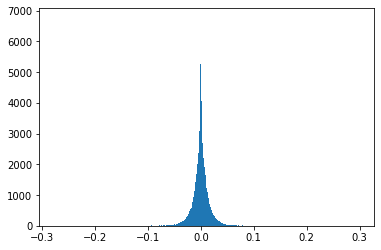

In [7]:
plt.hist(diff_acc[:,0], bins=1000)
plt.show()

In [7]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [8]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [9]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 5, firstkey = 150, nmax = 10):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [10]:
# get bar angle/pattern speed, and so on
fourier0 = read_fourier(0, lvl='lvl3')
out = main_bar_angle(fourier0)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply


In [11]:
def rotate_pos(pos, vel, ang):

    # tmp = np.random.rand(50, 200, 6)
    # print(tmp[0][0])
    # ang = 2.*np.pi
    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]])
    pos = np.swapaxes(pos, 0, 1)

    pos = np.matmul(Rmat, pos)

    pos = np.swapaxes(pos, 0, 1)
    return pos

In [91]:
init_bar_angle = np.mod(out['bar_angle'][500], 2.*np.pi)
pspeed = np.mean(out['pattern_speed'][495:505])

pos = sn.part2.pos.value
Rpos = rotate_pos(pos, -init_bar_angle)
acc = sn.part2.acce
Racc = rotate_pos(acc, -init_bar_angle)

print(pos[0], acc[0], Rpos[0], Racc[0])

rbf_accx = KNearestRBFInterpolant(Rpos, Racc[:,0])
rbf_accy = KNearestRBFInterpolant(Rpos, Racc[:,1])
rbf_accz = KNearestRBFInterpolant(Rpos, Racc[:,2])


[-0.03711823 -0.22563639  0.53114593] [  24312.22029344  -30371.15388962 -119714.6886226 ] [-0.22418168 -0.04507905  0.53114593] [ -19810.14264321  -33482.07419859 -119714.6886226 ]


In [43]:
pos = np.array([8., 0., 0.])
acc = np.array([rbf_accx([pos])[0], rbf_accy([pos])[0], rbf_accz([pos])[0]])
acc = acc * (u.km/u.s)**2/u.kpc
print(np.sqrt(8 * u.kpc * np.abs(acc)))

[241.11684913  26.39806867  87.19670174] km / s


In [143]:
def integrate_in_potential(rbf_accx, rbf_accy, rbf_accz, R, V, pspeed, dt_min=0.00001, eta=0.1, stop_early=True):
    pos = np.array([R, 0., 0.])
    vel = np.array([0, V, 0.])
    
    # subtract rotation of ref frame
    omega = np.array([0., 0., pspeed])
    vframe = np.cross(omega, pos)
#     print(vframe)
    
    vel -= vframe
    
    sgn = np.sign(vel[1])
#     print(sgn)
    
    pos_list = np.array([pos])
    vel_list = np.array([vel])
    
    
    acc = np.array([rbf_accx([pos])[0], rbf_accy([pos])[0], rbf_accz([pos])[0]])
    cfg = - np.cross(omega, np.cross(omega, pos))
    cnt = - 2. * np.cross(omega, vel)
    acc += cfg + cnt
    
    NMAX = 1000
    i = 0
    
    while True:
        dt = eta * np.linalg.norm(vel)/np.linalg.norm(acc)
        dt = np.maximum(dt, dt_min)
        
#         print(vel, dt)
        
        vel = vel + acc * dt / 2.0
#         print(vel)
        pos = pos + vel * dt
        
        
#         print(pos)
        acc = np.array([rbf_accx([pos])[0], rbf_accy([pos])[0], rbf_accz([pos])[0]])
        cfg = - np.cross(omega, np.cross(omega, pos))
        cnt = 2. * np.cross(omega, vel)
#         if i < 1000:
#             print(pos, acc)
#         print(np.linalg.norm(acc), np.linalg.norm(cfg), np.linalg.norm(cnt))
#         if i > 10:
#             break
        acc += cfg + cnt
        
        vel = vel + acc * dt / 2.0
        
#         print(pos, vel, acc)
        
        pos_list = np.vstack((pos_list, pos))
        vel_list = np.vstack((vel_list, vel))
        
        # check if we have crossed the x-axis
        if i>10 and stop_early:
            if np.sign(pos_list[-1][1]) != np.sign(pos_list[-2][1]) and np.sign(vel_list[-1][1]) == sgn:
                break
            
        i += 1
        if i >= NMAX:
            break
    
    return pos_list, vel_list

In [133]:
pos0, vel0 = integrate_in_potential(rbf_accx, rbf_accy, rbf_accz, 1.0, 100.0, pspeed, dt_min=0.0001, eta=0.1)

In [139]:
pos1, vel1 = integrate_in_potential(rbf_accx, rbf_accy, rbf_accz, 1.0, 100.0, pspeed, dt_min=0.0001, eta=0.01, stop_early=False)

[9.99833408e-01 6.27858415e-03 5.45894140e-05]
[9.99241039e-01 1.24982660e-02 2.18305847e-04]
[9.98223638e-01 1.86547336e-02 4.91222515e-04]
[9.96781753e-01 2.47437436e-02 8.73432924e-04]
[0.99491588 0.030761   0.00136506]
[0.99262646 0.03670215 0.00196625]
[0.98991383 0.04256276 0.00267718]
[0.98677824 0.04833835 0.00349799]
[0.98321989 0.05402446 0.0044288 ]
[0.97923888 0.0596166  0.00546977]
[0.97483523 0.06511035 0.00662105]
[0.97000861 0.0705014  0.00788289]
[0.96475906 0.07578531 0.00925531]
[0.9590862  0.0809581  0.01073886]
[0.9529895  0.08601553 0.01233342]
[0.9464681  0.09095374 0.01403922]
[0.93952113 0.09576863 0.01585648]
[0.93214766 0.10045582 0.01778522]
[0.92434644 0.10501066 0.01982572]
[0.91611599 0.1094284  0.02197827]
[0.90745476 0.11370392 0.02424319]
[0.89836125 0.11783181 0.02662047]
[0.88883375 0.12180665 0.02911028]
[0.8788704  0.12562277 0.03171265]
[0.86846931 0.12927466 0.03442756]
[0.85762863 0.13275681 0.03725502]
[0.84634624 0.13606368 0.04019511]
[0.8346

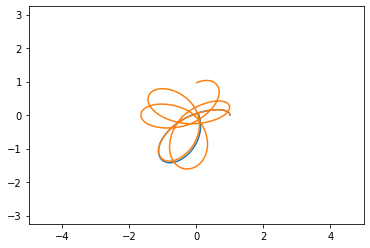

In [141]:
fig, ax = plt.subplots(1, 1)

ax.plot(pos0[:,0], pos0[:,1])
# ax.scatter(pos0[:,0], pos0[:,1])
ax.plot(pos1[:,0], pos1[:,1])
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 5))
# ax.set_ylim(-40, 40)
# ax.set_xlim(-)
plt.show()

In [145]:
NR=80
NV=100

Rlist = np.linspace(0.1, 8.0, NR)
Vlist = np.linspace(0.0, 250.0, NV)
met_arr = np.zeros((NR, NV))
for i,R in enumerate(tqdm(Rlist)):
    for j,V in enumerate(Vlist):
        pos, vel = integrate_in_potential(rbf_accx, rbf_accy, rbf_accz, R, V, pspeed, dt_min=0.0001, eta=0.1)
        diff = pos[0] - pos[-1]
        met_arr[i][j] = np.linalg.norm(diff)

A Jupyter Widget

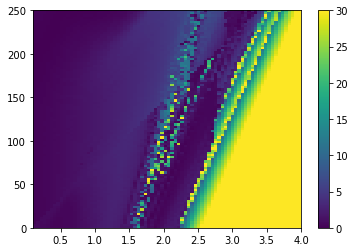

In [148]:
plt.imshow(met_arr.T, origin='lower', extent=[0.1, 4.0, 0.0, 250.0], vmin=0.0, vmax=30)
# plt.xlim(0, 10)
# plt.ylim(0, 10)
plt.axis('auto')

plt.colorbar()

plt.show()


In [206]:

pos = np.meshgrid()

-2488.6256367501237